# 01. Shear Component C_ell^{gamma gamma}
Sweep selected parameters and show inline responses for 01. Shear Component C_ell^{gamma gamma}.


In [23]:
from pathlib import Path
import re
import matplotlib.pyplot as plt
import numpy as np

try:
    import pyccl as ccl
except Exception as e:
    raise RuntimeError('Install pyccl first: pip install pyccl') from e

print('pyccl version:', getattr(ccl, '__version__', 'unknown'))

SETTINGS = {
    'output_dir': Path('/home/z/Zekang.Zhang/cosmo_playground/outputs/pyccl_shear'),
    'n_points': 7,
    'include_regex': [],
    'exclude_regex': [],
    'ell_min': 20,
    'ell_max': 3000,
    'n_ell': 120,
    'z_min': 0.001,
    'z_max': 3.0,
    'n_z': 600,
    'alpha': 2.0,
    'beta': 1.5,
    'z0': 0.5,
    'source_bins': [(0.20, 0.55), (0.55, 0.85), (0.85, 1.30), (1.30, 2.00)],
    'lens_bins': [(0.20, 0.45), (0.45, 0.70), (0.70, 0.95), (0.95, 1.20)],
    'transfer_function': 'eisenstein_hu',
    'parameters': {
        'omega_m': (0.24, 0.31, 0.40),
        'omega_c': (0.20, 0.26, 0.34),
        'omega_b': (0.040, 0.049, 0.060),
        'h': (0.60, 0.68, 0.76),
        'n_s': (0.92, 0.965, 1.02),
        'sigma8': (0.70, 0.82, 0.94),
        'w0': (-1.2, -1.0, -0.8),
        'wa': (-0.6, 0.0, 0.6),
        'm_nu': (0.0, 0.06, 0.30),
        'Omega_k': (-0.02, 0.0, 0.02),
        'Neff': (3.046, 3.046, 3.7),
        'a_ia': (-1.0, 0.5, 3.0),
        'eta_ia': (-2.0, 0.0, 2.0),
        'b_lens_1': (0.8, 1.2, 2.2),
        'b_lens_2': (0.8, 1.3, 2.3),
        'b_lens_3': (0.8, 1.4, 2.4),
        'b_lens_4': (0.8, 1.5, 2.5),
        'm_source_1': (-0.03, 0.00, 0.03),
        'm_source_2': (-0.03, 0.00, 0.03),
        'm_source_3': (-0.03, 0.00, 0.03),
        'm_source_4': (-0.03, 0.00, 0.03),
        'dz_source_1': (-0.08, 0.00, 0.08),
        'dz_source_2': (-0.08, 0.00, 0.08),
        'dz_source_3': (-0.08, 0.00, 0.08),
        'dz_source_4': (-0.08, 0.00, 0.08),
        'dz_lens_1': (-0.05, 0.00, 0.05),
        'dz_lens_2': (-0.05, 0.00, 0.05),
        'dz_lens_3': (-0.05, 0.00, 0.05),
        'dz_lens_4': (-0.05, 0.00, 0.05),
    }
}


pyccl version: 3.2.1


In [24]:
def fiducial_params(settings):
    return {k: float(v[1]) for k, v in settings['parameters'].items()}


def filter_params(settings, names):
    out = []
    for n in names:
        if n not in settings['parameters']:
            continue
        if settings['include_regex'] and not any(re.search(p, n) for p in settings['include_regex']):
            continue
        if settings['exclude_regex'] and any(re.search(p, n) for p in settings['exclude_regex']):
            continue
        out.append(n)
    return out


def make_grids(settings):
    ell = np.unique(np.geomspace(settings['ell_min'], settings['ell_max'], settings['n_ell']).astype(int))
    z = np.linspace(settings['z_min'], settings['z_max'], settings['n_z'])
    return ell, z


def smail_nz(z, alpha, beta, z0):
    nz = z**alpha * np.exp(-(z / z0) ** beta)
    nz[z <= 0] = 0.0
    area = np.trapezoid(nz, z)
    return nz / area if area > 0 else nz


def top_hat_bin(z, zmin, zmax):
    m = np.zeros_like(z)
    m[(z >= zmin) & (z < zmax)] = 1.0
    return m


def shift_nz(z, nz, dz):
    out = np.interp(z - dz, z, nz, left=0.0, right=0.0)
    area = np.trapezoid(out, z)
    return out / area if area > 0 else out


def build_tomo_nz(z, bins, base_nz, dz_prefix, params):
    out = []
    for i, (zmin, zmax) in enumerate(bins, start=1):
        nz = base_nz * top_hat_bin(z, zmin, zmax)
        out.append(shift_nz(z, nz, float(params.get(f'{dz_prefix}_{i}', 0.0))))
    return out


def ia_bias_curve(z, params, pivot_z=0.62):
    return float(params.get('a_ia', 0.0)) * ((1.0 + z)/(1.0 + pivot_z))**float(params.get('eta_ia', 0.0))


def build_cosmology(params, settings):
    omega_b = float(params['omega_b'])
    if 'omega_m' in params:
        omega_c = float(params['omega_m']) - omega_b
    else:
        omega_c = float(params['omega_c'])

    if omega_c <= 0:
        raise ValueError(f'Unphysical Omega_c={omega_c:.4g}; check omega_m and omega_b ranges.')

    kwargs = dict(
        Omega_c=omega_c,
        Omega_b=omega_b,
        h=float(params['h']),
        n_s=float(params['n_s']),
        sigma8=float(params['sigma8']),
        w0=float(params.get('w0', -1.0)),
        wa=float(params.get('wa', 0.0)),
        transfer_function=settings.get('transfer_function', 'eisenstein_hu'),
    )

    # Optional available parameters (used when present in SETTINGS['parameters']).
    if 'm_nu' in params:
        kwargs['m_nu'] = float(params['m_nu'])
    if 'Omega_k' in params:
        kwargs['Omega_k'] = float(params['Omega_k'])
    if 'Neff' in params:
        kwargs['Neff'] = float(params['Neff'])

    return ccl.Cosmology(**kwargs)


def build_tracers(cosmo, z, src_nz, lens_nz, params):
    ia = ia_bias_curve(z, params)
    src = [ccl.WeakLensingTracer(cosmo, dndz=(z, nz), ia_bias=(z, ia)) for nz in src_nz]
    lens = []
    for i, nz in enumerate(lens_nz, start=1):
        b = np.full_like(z, float(params.get(f'b_lens_{i}', 1.5)))
        lens.append(ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z, nz), bias=(z, b)))
    return src, lens


In [25]:
PARAMS_ALL = filter_params(SETTINGS, sorted(SETTINGS['parameters'].keys()))
# Avoid redundant sweep: omega_c is derived from omega_m when omega_m is present.
if 'omega_m' in PARAMS_ALL and 'omega_c' in PARAMS_ALL:
    PARAMS_ALL.remove('omega_c')
if not PARAMS_ALL:
    raise ValueError('No parameters selected after include/exclude filters.')

PHYS_GROUPS = {
    'expansion_geometry': ['omega_m', 'omega_b', 'h', 'Omega_k', 'w0', 'wa'],
    'growth_primordial': ['sigma8', 'n_s', 'm_nu', 'Neff'],
    'intrinsic_alignment': ['a_ia', 'eta_ia'],
    'shear_calibration': ['m_source_1', 'm_source_2', 'm_source_3', 'm_source_4'],
    'photoz_source': ['dz_source_1', 'dz_source_2', 'dz_source_3', 'dz_source_4'],
}

assigned = set()
GROUPED_PARAMS = {}
for g, names in PHYS_GROUPS.items():
    keep = [p for p in names if p in PARAMS_ALL]
    if keep:
        GROUPED_PARAMS[g] = keep
        assigned.update(keep)
leftover = [p for p in PARAMS_ALL if p not in assigned]

print('Parameter groups:')
for g, names in GROUPED_PARAMS.items():
    print(f'  {g}: {len(names)} params')
    print('   ->', names)
if leftover:
    print('Excluded (not physically relevant for this notebook):', leftover)

ell, z = make_grids(SETTINGS)
base_nz = smail_nz(z, SETTINGS['alpha'], SETTINGS['beta'], SETTINGS['z0'])
params0 = fiducial_params(SETTINGS)

src_nz0 = build_tomo_nz(z, SETTINGS['source_bins'], base_nz, 'dz_source', params0)
lens_nz0 = build_tomo_nz(z, SETTINGS['lens_bins'], base_nz, 'dz_lens', params0)
cosmo0 = build_cosmology(params0, SETTINGS)
src0, lens0 = build_tracers(cosmo0, z, src_nz0, lens_nz0, params0)


def component_matrix(cosmo, src_tr, lens_tr, p, ell):

    cls = []
    for i in range(len(src_tr)):
        for j in range(i, len(src_tr)):
            cl = ccl.angular_cl(cosmo, src_tr[i], src_tr[j], ell)
            cl *= (1.0 + float(p.get(f'm_source_{i+1}', 0.0)))
            cl *= (1.0 + float(p.get(f'm_source_{j+1}', 0.0)))
            cls.append(cl)
    return np.vstack(cls)


mat0 = component_matrix(cosmo0, src0, lens0, params0, ell)
print('baseline matrix shape [n_pairs, n_ell]:', mat0.shape)


def run_group(gname):
    PARAMS = GROUPED_PARAMS.get(gname, [])

    panel_data = []
    for pname in PARAMS:
        lo, _, hi = SETTINGS['parameters'][pname]
        vals = np.linspace(lo, hi, SETTINGS['n_points'])

        response_lines = []
        for val in vals:
            p = dict(params0)
            p[pname] = float(val)

            src_nz = build_tomo_nz(z, SETTINGS['source_bins'], base_nz, 'dz_source', p)
            lens_nz = build_tomo_nz(z, SETTINGS['lens_bins'], base_nz, 'dz_lens', p)
            try:
                cosmo = build_cosmology(p, SETTINGS)
            except ValueError as e:
                print(f'[skip] {pname}={val:.4g}: {e}')
                response_lines.append(np.full_like(ell, np.nan, dtype=float))
                continue

            src_tr, lens_tr = build_tracers(cosmo, z, src_nz, lens_nz, p)
            mat = component_matrix(cosmo, src_tr, lens_tr, p, ell)
            rel = (mat - mat0) / np.where(np.abs(mat0) > 0, np.abs(mat0), 1.0)
            rel_mean = np.mean(rel, axis=0)
            response_lines.append(rel_mean)

        panel_data.append((pname, vals, response_lines))

    n = len(panel_data)
    if n == 0:
        print(f'skip group: {gname} (no panel data)')
        return
    ncols = 3
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5.2 * ncols, 3.9 * nrows), squeeze=False)
    axes = axes.ravel()

    for ax in axes[n:]:
        ax.axis('off')

    for ax, (pname, vals, lines) in zip(axes, panel_data):
        cmap = plt.get_cmap('viridis')
        colors = cmap(np.linspace(0, 1, len(vals)))
        x = np.asarray(ell)
        x_has_pos = np.any(np.isfinite(x) & (x > 0))
        valid_any = False

        for color, y in zip(colors, lines):
            y = np.asarray(y)
            m = np.isfinite(x) & np.isfinite(y)
            if not np.any(m):
                continue
            valid_any = True
            ax.plot(x[m], y[m], color=color, lw=1.3)

        ax.axhline(0.0, color='k', lw=0.8, alpha=0.5)
        if x_has_pos:
            ax.set_xscale('log')
        ax.set_title(pname)
        ax.set_xlabel('ell')
        ax.set_ylabel('mean fractional response')
        ax.grid(alpha=0.2)

        if not valid_any:
            ax.text(0.5, 0.5, 'No valid curves', transform=ax.transAxes,
                    ha='center', va='center', fontsize=9)

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=float(vals.min()), vmax=float(vals.max())))
        fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.02, label=pname)

    fig.suptitle('Shear $C_\ell^{\gamma\gamma}$: mean fractional response vs ell | group: ' + gname, y=1.02)
    fig.tight_layout()
    plt.show()


Parameter groups:
  expansion_geometry: 6 params
   -> ['omega_m', 'omega_b', 'h', 'Omega_k', 'w0', 'wa']
  growth_primordial: 4 params
   -> ['sigma8', 'n_s', 'm_nu', 'Neff']
  intrinsic_alignment: 2 params
   -> ['a_ia', 'eta_ia']
  shear_calibration: 4 params
   -> ['m_source_1', 'm_source_2', 'm_source_3', 'm_source_4']
  photoz_source: 4 params
   -> ['dz_source_1', 'dz_source_2', 'dz_source_3', 'dz_source_4']
Excluded (not physically relevant for this notebook): ['b_lens_1', 'b_lens_2', 'b_lens_3', 'b_lens_4', 'dz_lens_1', 'dz_lens_2', 'dz_lens_3', 'dz_lens_4']
baseline matrix shape [n_pairs, n_ell]: (10, 119)


## Group: `expansion_geometry`


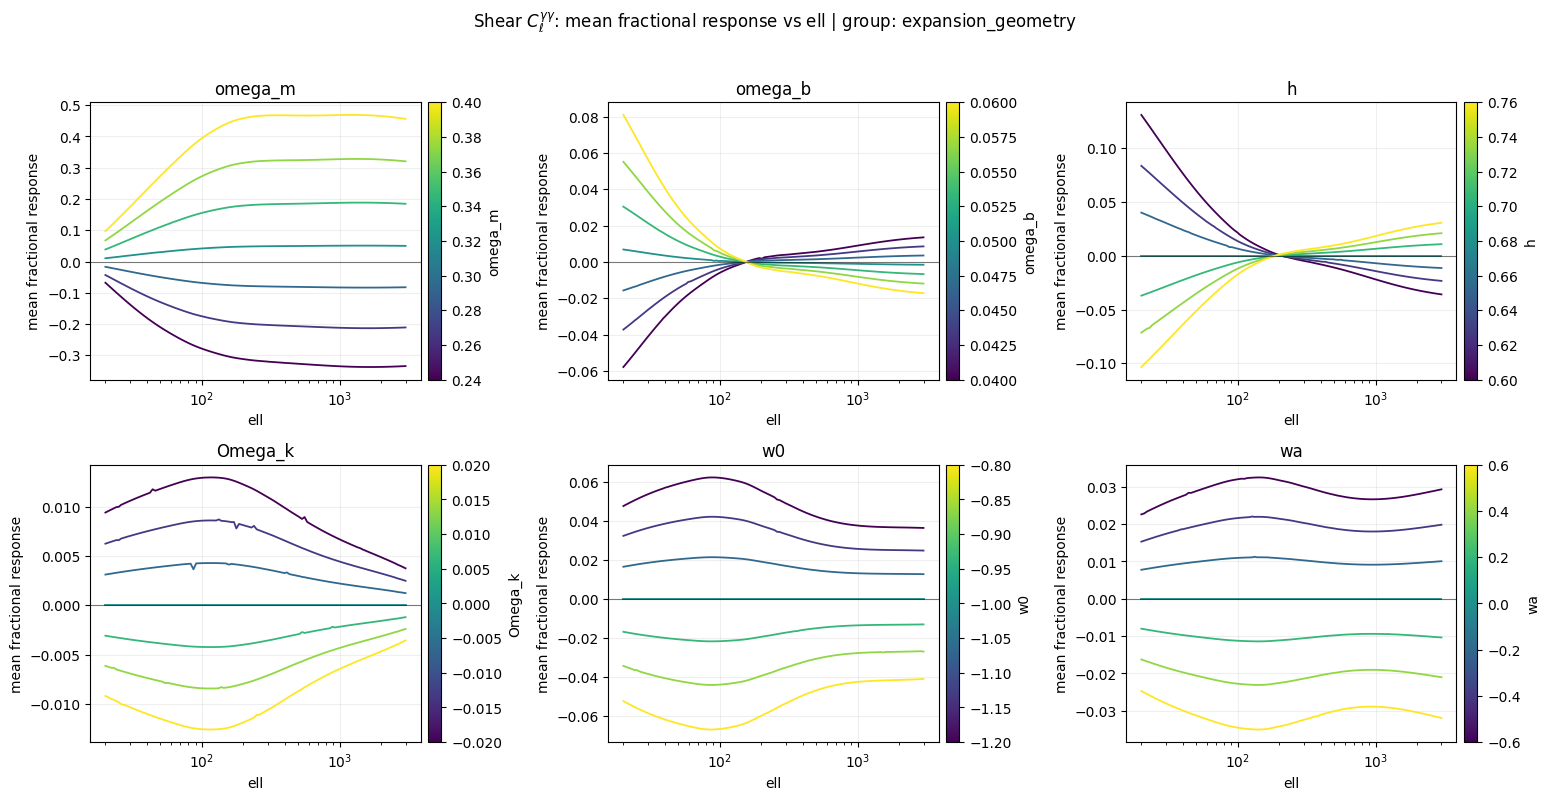

In [26]:
run_group('expansion_geometry')


## Group: `growth_primordial`


[skip] m_nu=0.05: m_nu < 0.059226785828928465 incompatible with mass hierarchy


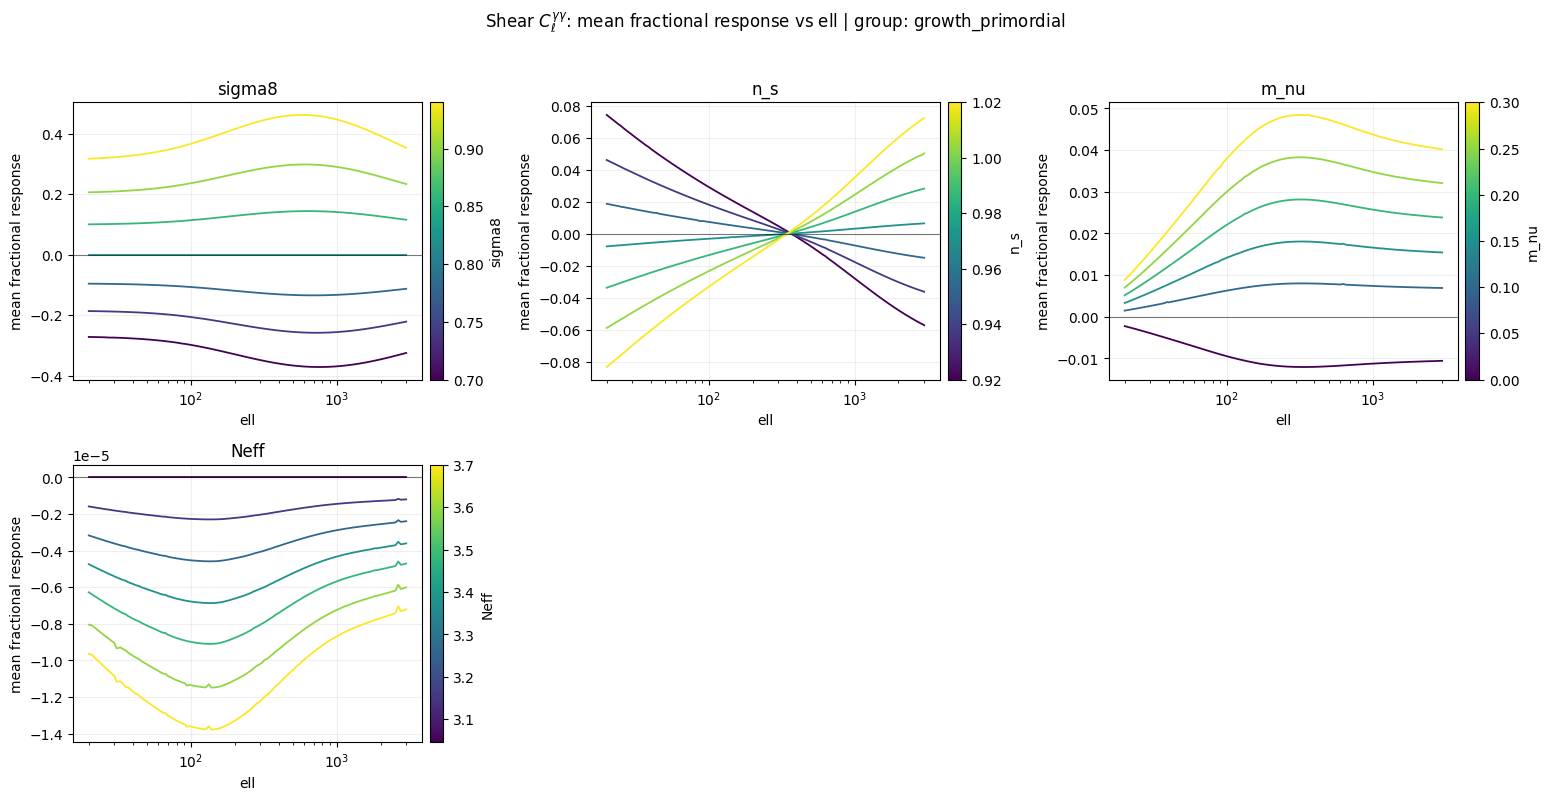

In [27]:
run_group('growth_primordial')


## Group: `intrinsic_alignment`


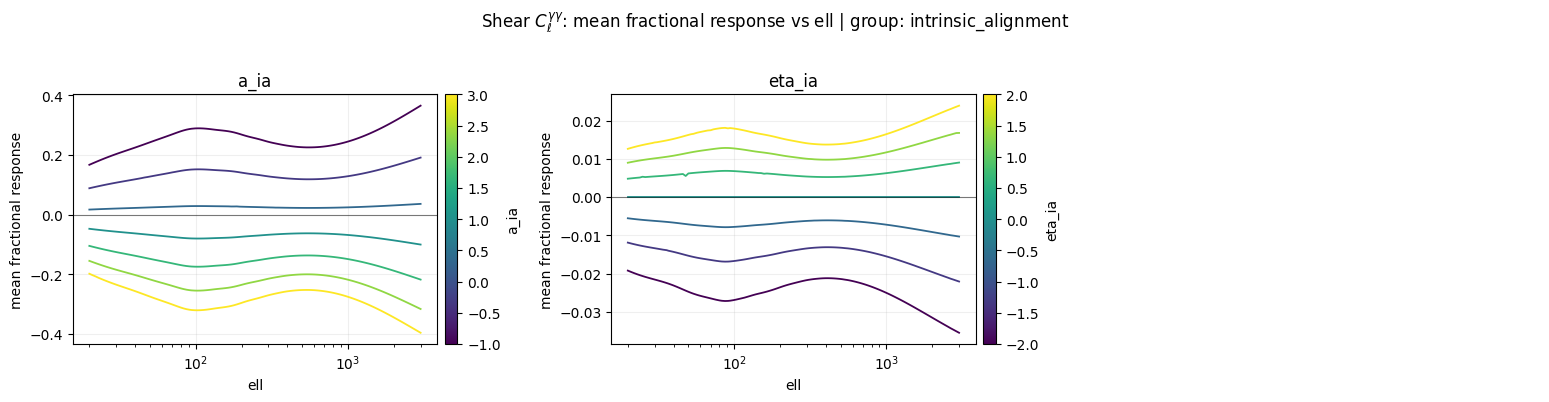

In [28]:
run_group('intrinsic_alignment')


## Group: `shear_calibration`


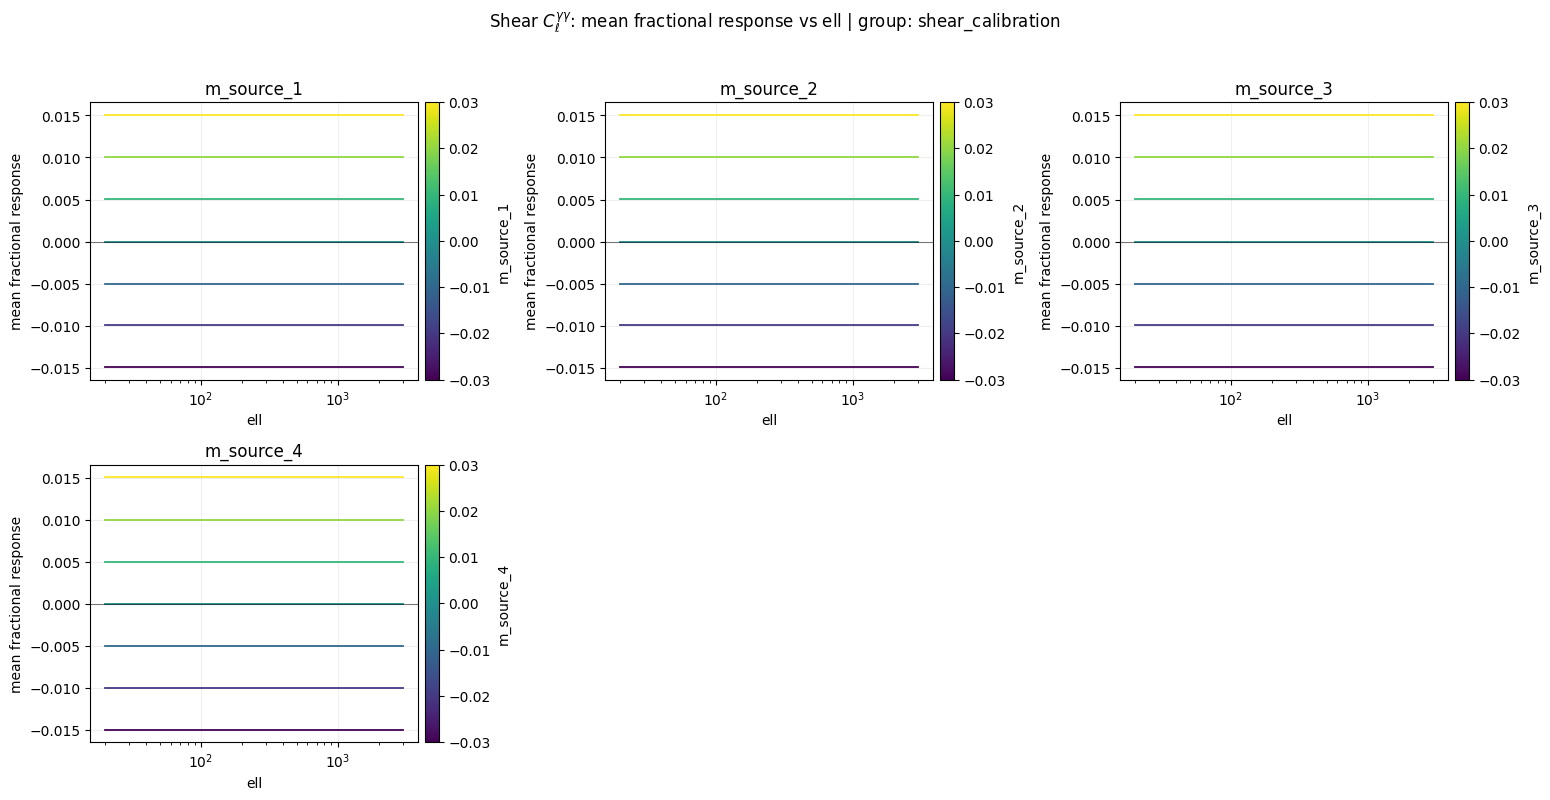

In [29]:
run_group('shear_calibration')


## Group: `photoz_source`


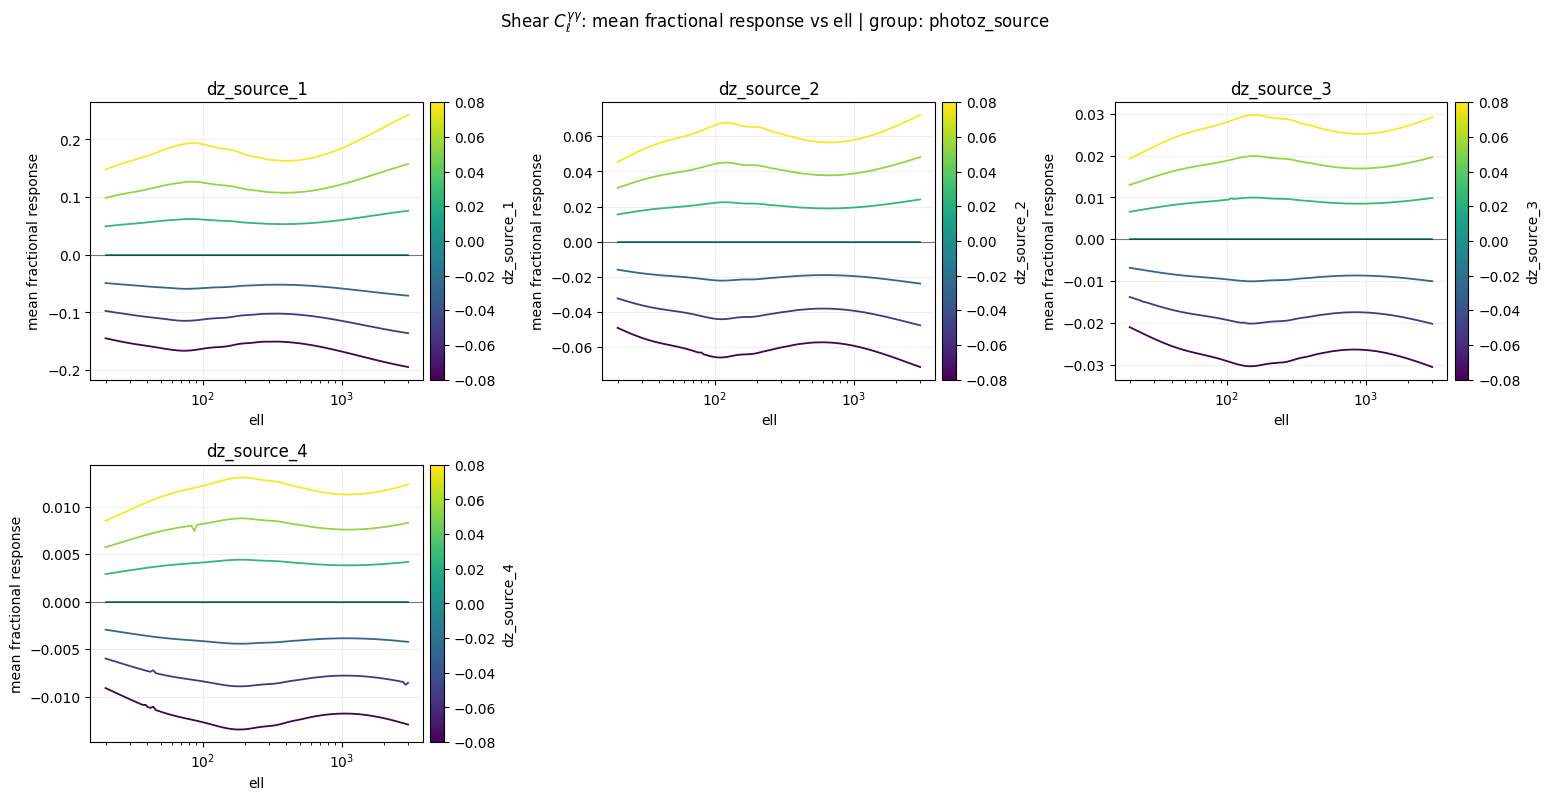

In [30]:
run_group('photoz_source')
